# PerfForesightConsumerType: Perfect foresight consumption-saving

In [1]:
# Initial imports and notebook setup, click arrow to show

from copy import copy

import matplotlib.pyplot as plt
import numpy as np

from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType
from HARK.utilities import plotFuncs

mystr = lambda number: "{:.4f}".format(number)

The module $\texttt{HARK.ConsumptionSaving.ConsIndShockModel}$ concerns consumption-saving models with idiosyncratic shocks to (non-capital) income.  All of the models assume CRRA utility with geometric discounting, no bequest motive, and income shocks are fully transitory or fully permanent.

$\texttt{ConsIndShockModel}$ currently includes three models:
1. A very basic "perfect foresight" model with no uncertainty.
2. A model with risk over transitory and permanent income shocks.
3. The model described in (2), with an interest rate for debt that differs from the interest rate for savings.

This notebook provides documentation for the first of these three models.
$\newcommand{\CRRA}{\rho}$
$\newcommand{\DiePrb}{\mathsf{D}}$
$\newcommand{\PermGroFac}{\Gamma}$
$\newcommand{\Rfree}{\mathsf{R}}$
$\newcommand{\DiscFac}{\beta}$

## Statement of perfect foresight consumption-saving model

The $\texttt{PerfForesightConsumerType}$ class the problem of a consumer with Constant Relative Risk Aversion utility
${\CRRA}$
\begin{equation}
U(C) = \frac{C^{1-\CRRA}}{1-\rho},
\end{equation}
has perfect foresight about everything except whether he will die between the end of period $t$ and the beginning of period $t+1$, which occurs with probability $\DiePrb_{t+1}$.  Permanent labor income $P_t$ grows from period $t$ to period $t+1$ by factor $\PermGroFac_{t+1}$.

At the beginning of period $t$, the consumer has an amount of market resources $M_t$ (which includes both market wealth and currrent income) and must choose how much of those resources to consume $C_t$ and how much to retain in a riskless asset $A_t$, which will earn return factor $\Rfree$.  The consumer cannot necessarily borrow arbitarily; instead, he might be constrained to have a wealth-to-income ratio at least as great as some "artificial borrowing constraint" $\underline{a} \leq 0$.

The agent's flow of future utility $U(C_{t+n})$ from consumption is geometrically discounted by factor $\DiscFac$ per period. If the consumer dies, he receives zero utility flow for the rest of time.

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
V_t(M_t,P_t) &=& \max_{C_t}~U(C_t) ~+ \DiscFac (1 - \DiePrb_{t+1}) V_{t+1}(M_{t+1},P_{t+1}), \\
& s.t. & \\
A_t &=& M_t - C_t, \\
A_t/P_t &\geq& \underline{a}, \\
M_{t+1} &=& \Rfree A_t + Y_{t+1}, \\
Y_{t+1} &=& P_{t+1}, \\
P_{t+1} &=& \PermGroFac_{t+1} P_t.
\end{eqnarray*}

The consumer's problem is characterized by a coefficient of relative risk aversion $\CRRA$, an intertemporal discount factor $\DiscFac$, an interest factor $\Rfree$, and age-varying sequences of the permanent income growth factor $\PermGroFac_t$ and survival probability $(1 - \DiePrb_t)$.

While it does not reduce the computational complexity of the problem (as permanent income is deterministic, given its initial condition $P_0$), HARK represents this problem with *normalized* variables (represented in lower case), dividing all real variables by permanent income $P_t$ and utility levels by $P_t^{1-\CRRA}$.  The Bellman form of the model thus reduces to:

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t}~U(c_t) ~+ \DiscFac (1 - \DiePrb_{t+1}) \PermGroFac_{t+1}^{1-\CRRA} v_{t+1}(m_{t+1}), \\
& s.t. & \\
a_t &=& m_t - c_t, \\
a_t &\geq& \underline{a}, \\
m_{t+1} &=& \Rfree/\PermGroFac_{t+1} a_t + 1.
\end{eqnarray*}

## Solution method for PerfForesightConsumerType

Because of the assumptions of CRRA utility, no risk other than mortality, and no artificial borrowing constraint, the problem has a closed form solution.  In fact, the consumption function is perfectly linear, and the value function composed with the inverse utility function is also linear.  The mathematical solution of this model is described in detail in the lecture notes [PerfForesightCRRA](http://econ.jhu.edu/people/ccarroll/public/lecturenotes/consumption/PerfForesightCRRA).

The one period problem for this model is solved by the function $\texttt{solveConsPerfForesight}$, which creates an instance of the class $\texttt{ConsPerfForesightSolver}$. To construct an instance of the class $\texttt{PerfForesightConsumerType}$, several parameters must be passed to its constructor as shown in the table below.

## Example parameter values to construct an instance of PerfForesightConsumerType

| Parameter | Description | Code | Example value | Time-varying? |
| :---: | --- | --- | --- | --- |
| $\DiscFac$ |Intertemporal discount factor  | $\texttt{DiscFac}$ | $0.96$ |  |
| $\CRRA $ |Coefficient of relative risk aversion | $\texttt{CRRA}$ | $2.0$ | |
| $\Rfree$ | Risk free interest factor | $\texttt{Rfree}$ | $1.03$ | |
| $1 - \DiePrb_{t+1}$ |Survival probability | $\texttt{LivPrb}$ | $[0.98]$ | $\surd$ |
|$\PermGroFac_{t+1}$|Permanent income growth factor|$\texttt{PermGroFac}$| $[1.01]$ | $\surd$ |
|$\underline{a}$|Artificial borrowing constraint|$\texttt{BoroCnstArt}$| $None$ |  |
|$(none)$|Maximum number of gridpoints in consumption function |$\texttt{aXtraCount}$| $200$ |  |
|$T$| Number of periods in this type's "cycle" |$\texttt{T_cycle}$| $1$ | |
|(none)| Number of times the "cycle" occurs |$\texttt{cycles}$| $0$ | |

Note that the survival probability and income growth factor have time subscripts; likewise, the example values for these parameters are *lists* rather than simply single floats.  This is because those parameters are *time-varying*: their values can depend on which period of the problem the agent is in.  All time-varying parameters *must* be specified as lists, even if the same value occurs in each period for this type.

The artificial borrowing constraint can be any non-positive $\texttt{float}$, or it can be $\texttt{None}$ to indicate no artificial borrowing constraint.  The maximum number of gridpoints in the consumption function is only relevant if the borrowing constraint is not $\texttt{None}$; without an upper bound on the number of gridpoints, kinks in the consumption function will propagate indefinitely in an infinite horizon model if there is a borrowing constraint, eventually resulting in an overflow error.  If there is no artificial borrowing constraint, then the number of gridpoints used to represent the consumption function is always exactly two.

The last two parameters in the table specify the "nature of time" for this type: the number of (non-terminal) periods in this type's "cycle", and the number of times that the "cycle" occurs.  *Every* subclass of $\texttt{AgentType}$ uses these two code parameters to define the nature of time.  Here, $\texttt{T_cycle}$ has the value $1$, indicating that there is exactly one period in the cycle, while $\texttt{cycles}$ is $0$, indicating that the cycle is repeated in *infinite* number of times-- it is an infinite horizon model, with the same "kind" of period repeated over and over.

In contrast, we could instead specify a life-cycle model by setting $\texttt{T_cycle}$ to $1$, and specifying age-varying sequences of income growth and survival probability.  In all cases, the number of elements in each time-varying parameter should exactly equal $\texttt{T_cycle}$.

The parameter $\texttt{AgentCount}$ specifies how many consumers there are of this *type*-- how many individuals have these exact parameter values and are *ex ante* homogeneous.  This information is not relevant for solving the model, but is needed in order to simulate a population of agents, introducing *ex post* heterogeneity through idiosyncratic shocks.  Of course, simulating a perfect foresight model is quite boring, as there are *no* idiosyncratic shocks other than death!

The cell below defines a dictionary that can be passed to the constructor method for $\texttt{PerfForesightConsumerType}$, with the values from the table here.

In [2]:
PerfForesightDict = {
    # Parameters actually used in the solution method
    "CRRA": 2.0,  # Coefficient of relative risk aversion
    "Rfree": 1.03,  # Interest factor on assets
    "DiscFac": 0.96,  # Default intertemporal discount factor
    "LivPrb": [0.98],  # Survival probability
    "PermGroFac": [1.01],  # Permanent income growth factor
    "BoroCnstArt": None,  # Artificial borrowing constraint
    "aXtraCount": 200,  # Maximum number of gridpoints in consumption function
    # Parameters that characterize the nature of time
    "T_cycle": 1,  # Number of periods in the cycle for this agent type
    "cycles": 0,  # Number of times the cycle occurs (0 --> infinitely repeated)
}

## Solving and examining the solution of the perfect foresight model

With the dictionary we have just defined, we can create an instance of $\texttt{PerfForesightConsumerType}$ by passing the dictionary to the class (as if the class were a function).  This instance can then be solved by invoking its $\texttt{solve}$ method.

In [3]:
PFexample = PerfForesightConsumerType(**PerfForesightDict)
PFexample.cycles = 0
PFexample.solve()

The $\texttt{solve}$ method fills in the instance's attribute $\texttt{solution}$ as a time-varying list of solutions to each period of the consumer's problem.  In this case, $\texttt{solution}$ will be a list with exactly one instance of the class $\texttt{ConsumerSolution}$, representing the solution to the infinite horizon model we specified.

In [4]:
print(PFexample.solution)

Each element of $\texttt{solution}$ has a few attributes. To see all of them, we can use the \texttt{vars} built in function:

the consumption functions reside in the attribute $\texttt{cFunc}$ of each element of $\texttt{ConsumerType.solution}$.  This method creates a (time varying) attribute $\texttt{cFunc}$ that contains a list of consumption functions.

In [5]:
print(vars(PFexample.solution[0]))

{'cFunc': <HARK.interpolation.LinearInterp object at 0x7fa39d777210>, 'vFunc': <HARK.ConsumptionSaving.ConsIndShockModel.ValueFunc object at 0x7fa39d778350>, 'vPfunc': <HARK.ConsumptionSaving.ConsIndShockModel.MargValueFunc object at 0x7fa39d778d10>, 'vPPfunc': <HARK.utilities.NullFunc object at 0x7fa39d7788d0>, 'mNrmMin': -50.49994992551661, 'hNrm': 50.49994992551661, 'MPCmin': 0.04428139169919579, 'MPCmax': 0.04428139169919579, 'mNrmSS': -50.49991081984768}


The two most important attributes of a single period solution of this model are the (normalized) consumption function $\texttt{cFunc}$ and the (normalized) value function $\texttt{vFunc}$.  Let's plot those functions near the lower bound of the permissible state space (the attribute $\texttt{mNrmMin}$ tells us the lower bound of $m_t$ where the consumption function is defined).

Linear perfect foresight consumption function:


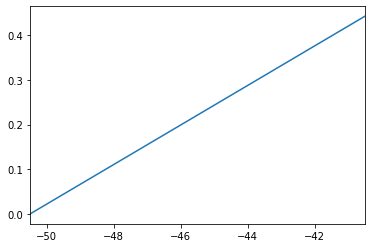

In [6]:
print("Linear perfect foresight consumption function:")
mMin = PFexample.solution[0].mNrmMin
plotFuncs(PFexample.solution[0].cFunc, mMin, mMin + 10.0)

Perfect foresight value function:


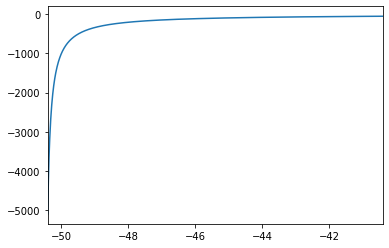

In [7]:
print("Perfect foresight value function:")
plotFuncs(PFexample.solution[0].vFunc, mMin + 0.1, mMin + 10.1)

An element of $\texttt{solution}$ also includes the (normalized) marginal value function $\texttt{vPfunc}$, and the lower and upper bounds of the marginal propensity to consume (MPC) $\texttt{MPCmin}$ and $\texttt{MPCmax}$.  Note that with a linear consumption function, the MPC is constant, so its lower and upper bound are identical.

### Liquidity constrained perfect foresight example

Without an artificial borrowing constraint, a perfect foresight consumer is free to borrow against the PDV of his entire future stream of labor income-- his "human wealth" $\texttt{hNrm}$-- and he will consume a constant proportion of his total wealth (market resources plus human wealth).  If we introduce an artificial borrowing constraint, both of these features vanish.  In the cell below, we define a parameter dictionary that prevents the consumer from borrowing *at all*, create and solve a new instance of $\texttt{PerfForesightConsumerType}$ with it, and then plot its consumption function.

Liquidity constrained perfect foresight consumption function:


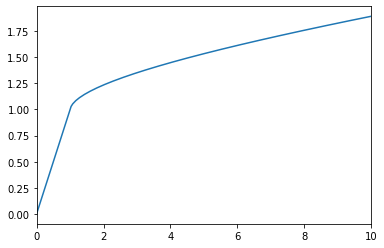

In [8]:
LiqConstrDict = copy(PerfForesightDict)
LiqConstrDict["BoroCnstArt"] = 0.0  # Set the artificial borrowing constraint to zero

LiqConstrExample = PerfForesightConsumerType(**LiqConstrDict)
LiqConstrExample.cycles = 0  # Make this type be infinite horizon
LiqConstrExample.solve()

print("Liquidity constrained perfect foresight consumption function:")
plotFuncs(LiqConstrExample.solution[0].cFunc, 0.0, 10.0)

At this time, the value function for a perfect foresight consumer with an artificial borrowing constraint is not computed nor included as part of its $\texttt{solution}$.

## Simulating the perfect foresight consumer model

Suppose we wanted to simulate many consumers who share the parameter values that we passed to $\texttt{PerfForesightConsumerType}$-- an *ex ante* homogeneous *type* of consumers.  To do this, our instance would have to know *how many* agents there are of this type, as well as their initial levels of assets $a_t$ and permanent income $P_t$.

### Setting simulation parameters

Let's fill in this information by passing another dictionary to $\texttt{PFexample}$ with simulation parameters.  The table below lists the parameters that an instance of $\texttt{PerfForesightConsumerType}$ needs in order to successfully simulate its model using the $\texttt{simulate}$ method.

| Description | Code | Example value |
| :---: | --- | --- |
| Number of consumers of this type | $\texttt{AgentCount}$ | $10000$ |
| Number of periods to simulate | $\texttt{T_sim}$ | $120$ |
| Mean of initial log (normalized) assets | $\texttt{aNrmInitMean}$ | $-6.0$ |
| Stdev of initial log  (normalized) assets | $\texttt{aNrmInitStd}$ | $1.0$ |
| Mean of initial log permanent income | $\texttt{pLvlInitMean}$ | $0.0$ |
| Stdev of initial log permanent income | $\texttt{pLvlInitStd}$ | $0.0$ |
| Aggregrate productivity growth factor | $\texttt{PermGroFacAgg}$ | $1.0$ |
| Age after which consumers are automatically killed | $\texttt{T_age}$ | $None$ |

We have specified the model so that initial assets and permanent income are both distributed lognormally, with mean and standard deviation of the underlying normal distributions provided by the user.

The parameter $\texttt{PermGroFacAgg}$ exists for compatibility with more advanced models that employ aggregate productivity shocks; it can simply be set to 1.

In infinite horizon models, it might be useful to prevent agents from living extraordinarily long lives through a fortuitous sequence of mortality shocks.  We have thus provided the option of setting $\texttt{T_age}$ to specify the maximum number of periods that a consumer can live before they are automatically killed (and replaced with a new consumer with initial state drawn from the specified distributions).  This can be turned off by setting it to $\texttt{None}$.

The cell below puts these parameters into a dictionary, then gives them to $\texttt{PFexample}$.  Note that all of these parameters *could* have been passed as part of the original dictionary; we omitted them above for simplicity.

In [9]:
SimulationParams = {
    "AgentCount": 10000,  # Number of agents of this type
    "T_sim": 120,  # Number of periods to simulate
    "aNrmInitMean": -6.0,  # Mean of log initial assets
    "aNrmInitStd": 1.0,  # Standard deviation of log initial assets
    "pLvlInitMean": 0.0,  # Mean of log initial permanent income
    "pLvlInitStd": 0.0,  # Standard deviation of log initial permanent income
    "PermGroFacAgg": 1.0,  # Aggregate permanent income growth factor
    "T_age": None,  # Age after which simulated agents are automatically killed
}

# This implicitly uses the assignParameters method of AgentType
PFexample(**SimulationParams)

To generate simulated data, we need to specify which variables we want to track the "history" of for this instance.  To do so, we set the $\texttt{track_vars}$ attribute of our $\texttt{PerfForesightConsumerType}$ instance to be a list of strings with the simulation variables we want to track.

In this model, valid elments of $\texttt{track_vars}$ include $\texttt{mNrmNow}$, $\texttt{cNrmNow}$, $\texttt{aNrmNow}$, and $\texttt{pLvlNow}$.  Because this model has no idiosyncratic shocks, our simulated data will be quite boring.

### Generating simulated data

Before simulating, the $\texttt{initializeSim}$ method must be invoked.  This resets our instance back to its initial state, drawing a set of initial $\texttt{aNrmNow}$ and $\texttt{pLvlNow}$ values from the specified distributions and storing them in the attributes $\texttt{aNrmNow_init}$ and $\texttt{pLvlNow_init}$.  It also resets this instance's internal random number generator, so that the same initial states will be set every time $\texttt{initializeSim}$ is called.  In models with non-trivial shocks, this also ensures that the same sequence of shocks will be generated on every simulation run.

Finally, the $\texttt{simulate}$ method can be called.

In [10]:
PFexample.track_vars = ["mNrmNow"]
PFexample.initializeSim()
PFexample.simulate()

Each simulation variable $\texttt{X}$ named in $\texttt{track_vars}$ will have the *history* of that variable for each agent stored in the attribute $\texttt{X_hist}$ as an array of shape $(\texttt{T_sim},\texttt{AgentCount})$.  To see that the simulation worked as intended, we can plot the mean of $m_t$ in each simulated period:

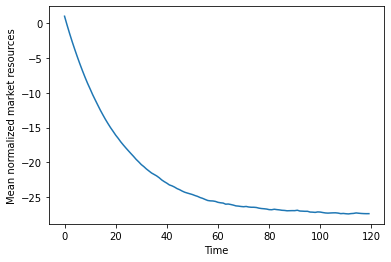

In [11]:
plt.plot(np.mean(PFexample.history["mNrmNow"], axis=1))
plt.xlabel("Time")
plt.ylabel("Mean normalized market resources")
plt.show()

A perfect foresight consumer can borrow against the PDV of his future income-- his human wealth-- and thus as time goes on, our simulated agents approach the (very negative) steady state level of $m_t$ while being steadily replaced with consumers with roughly $m_t=1$.

The slight wiggles in the plotted curve are due to consumers randomly dying and being replaced; their replacement will have an initial state drawn from the distributions specified by the user.  To see the current distribution of ages, we can look at the attribute $\texttt{t_age}$.

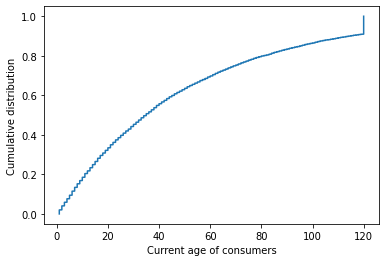

In [12]:
N = PFexample.AgentCount
F = np.linspace(0.0, 1.0, N)
plt.plot(np.sort(PFexample.t_age), F)
plt.xlabel("Current age of consumers")
plt.ylabel("Cumulative distribution")
plt.show()

The distribution is (discretely) exponential, with a point mass at 120 with consumers who have survived since the beginning of the simulation.

One might wonder why HARK requires users to call $\texttt{initializeSim}$ before calling $\texttt{simulate}$: Why doesn't $\texttt{simulate}$ just call $\texttt{initializeSim}$ as its first step?  We have broken up these two steps so that users can simulate some number of periods, change something in the environment, and then resume the simulation.

When called with no argument, $\texttt{simulate}$ will simulate the model for $\texttt{T_sim}$ periods.  The user can optionally pass an integer specifying the number of periods to simulate (which should not exceed $\texttt{T_sim}$).

In the cell below, we simulate our perfect foresight consumers for 80 periods, then seize a bunch of their assets (dragging their wealth even more negative), then simulate for the reamining 40 periods.

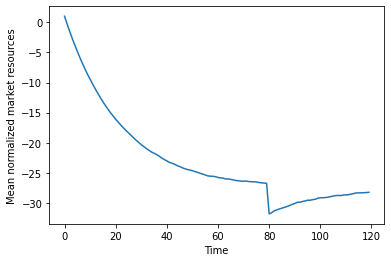

In [13]:
PFexample.initializeSim()
PFexample.simulate(80)
PFexample.state_prev['aNrmNow'] += -5.0  # Adjust all simulated consumers' assets downward by 5
PFexample.simulate(40)

plt.plot(np.mean(PFexample.history["mNrmNow"], axis=1))
plt.xlabel("Time")
plt.ylabel("Mean normalized market resources")
plt.show()